In [30]:
#Load Packages
import glob
import pandas as pd
import re
import numpy as np
from plotnine import *
import warnings
from sklearn.cluster import KMeans

In [6]:
warnings.filterwarnings('ignore')

In [7]:
#RDQ
rdqPre = pd.read_spss('../Data/PrePostMeasures/RDQPre_1.sav')
rdqPost = pd.read_spss('../Data/PrePostMeasures/RDQPost_1.sav')
rdqPre

#Satisfaction
satOld = pd.read_spss('../Data/PHPSatisfaction/EndofTreatmentSurveyData/EOT Verfication_1.sav')
satNew = pd.read_spss('../Data/DischargePacket/2022-06-06 dc.sav')

#Diagnosis
dx = pd.read_spss('../Data/DemosDx/Diagnosis_1.sav')
demo = pd.read_spss('../Data/DemosDx/Demographics Form_1.sav')

In [8]:
#RDQ Arrangement: Symptoms, Coping Ability, Positive Mental Health, Functioning, Well-Being and Life Satisfaction
rdqPre.ID1 = rdqPre.ID1.astype('object')
rdqPost.ID1 = rdqPost.ID1.astype('object')
rdqPre = rdqPre.replace(
    {'not at all or rarely true': 0, 'sometimes true': 1, 'often or almost always true': 2})
rdqPost = rdqPost.replace(
    {'not at all or rarely true': 0, 'sometimes true': 1, 'often or almost always true': 2})

#Convert reverse items
for i in [29,30,48,49,50] :
    colname1 = 'rdqpre_' + str(i) + '_1'
    colname2 = 'rdqpost_' + str(i) + '_1'
    rdqPre[colname1] = abs(rdqPre[colname1].astype('float') - 2)
    rdqPost[colname2] = abs(rdqPost[colname2].astype('float') - 2)

In [9]:
rdqPre['rdqpre_29_1'] = abs(rdqPre['rdqpre_29_1'].astype('float') - 2)
rdqPre['rdqpre_30_1'] = abs(rdqPre['rdqpre_30_1'].astype('float') - 2)
rdqPre['rdqpre_48_1'] = abs(rdqPre['rdqpre_48_1'].astype('float') - 2)
rdqPre['rdqpre_49_1'] = abs(rdqPre['rdqpre_49_1'].astype('float') - 2)
rdqPre['rdqpre_50_1'] = abs(rdqPre['rdqpre_50_1'].astype('float') - 2)
rdqPre['rdqpre_51_1'] = abs(rdqPre['rdqpre_51_1'].astype('float') - 2)
rdqPre['rdqpre_52_1'] = abs(rdqPre['rdqpre_52_1'].astype('float') - 2)

rdqPost['rdqpost_29_1'] = abs(rdqPost['rdqpost_29_1'].astype('float') - 2)
rdqPost['rdqpost_30_1'] = abs(rdqPost['rdqpost_30_1'].astype('float') - 2)
rdqPost['rdqpost_48_1'] = abs(rdqPost['rdqpost_48_1'].astype('float') - 2)
rdqPost['rdqpost_49_1'] = abs(rdqPost['rdqpost_49_1'].astype('float') - 2)
rdqPost['rdqpost_50_1'] = abs(rdqPost['rdqpost_50_1'].astype('float') - 2)
rdqPost['rdqpost_51_1'] = abs(rdqPost['rdqpost_51_1'].astype('float') - 2)
rdqPost['rdqpost_52_1'] = abs(rdqPost['rdqpost_52_1'].astype('float') - 2)

In [10]:
#Agregate scores of different RDQ sections
rdqPre['pre_sym'] = rdqPre.iloc[:,1:26].mean(axis = 1)
rdqPre['pre_cope'] = rdqPre.iloc[:,26:31].mean(axis = 1)
rdqPre['pre_pmh'] = rdqPre.iloc[:,31:43].mean(axis = 1)
rdqPre['pre_fun'] = rdqPre.iloc[:,43:53].mean(axis = 1)
rdqPre['pre_well'] = rdqPre.iloc[:,53:61].mean(axis = 1)

rdqPost['post_sym'] = rdqPost.iloc[:,1:26].mean(axis = 1)
rdqPost['post_cope'] = rdqPost.iloc[:,26:31].mean(axis = 1)
rdqPost['post_pmh'] = rdqPost.iloc[:,31:43].mean(axis = 1)
rdqPost['post_fun'] = rdqPost.iloc[:,43:53].mean(axis = 1)
rdqPost['post_well'] = rdqPost.iloc[:,53:61].mean(axis = 1)

rdq = pd.merge(rdqPre, rdqPost, on = 'ID1', how = 'inner')

In [11]:
#Merge old and new overall satisfaction 
satGlobalOld = satOld.loc[:,['PHP_ID_1','OVERALL_1', 'IMPRV_1']].rename(columns = {'PHP_ID_1': 'ID1', 'OVERALL_1': 'overall1',
                                                                                   'IMPRV_1': 'imprv1'})
satGlobalNew = satNew.loc[:,['id1','overall_1', 'imprv_1']].rename(columns = {'id1': 'ID1', 'overall_1': 'overall1',
                                                                              'imprv_1': 'imprv1'})
satGlobal = pd.concat([satGlobalOld, satGlobalNew],axis = 0)
satGlobal = satGlobal[satGlobal.ID1 != 0]
satGlobal.ID1 = satGlobal.ID1.astype('object')

print('N of people who were administered with the discharge package:', satGlobal.shape[0]) 

N of people who were administered with the discharge package: 3811


In [12]:
print('Overall Satisfaction Missing Values = ', sum(satGlobal.overall1.isnull()),'\n'
      'Overall Improvement Missing Values = ', sum(satGlobal.imprv1.isnull()))

Overall Satisfaction Missing Values =  49 
Overall Improvement Missing Values =  46


In [13]:
df = pd.merge(satGlobal, rdq, how = 'inner', on = 'ID1')
df = pd.merge(df, dx, how = 'left', on = 'ID1')
df = pd.merge(df, demo, how = 'left', on = 'ID1')

In [14]:
df = df[df.filter(regex='rdqpre').isnull().sum(axis=1) <=10]
df = df[df.filter(regex='rdqpost').isnull().sum(axis=1) <=10]
print('People who completed the program and have less than 10 missing values in RDQ at intake and discharge', 
      df.shape[0])

People who completed the program and have less than 10 missing values in RDQ at intake and discharge 2711


In [15]:
df_long0 = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')

df_long0 = \
pd.melt(df_long0, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long0.rdqvar = df_long0.rdqvar.astype('category').cat.reorder_categories(
    ['pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well'])
df_long0.satvar = df_long0.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])


df_long = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')
df_long = \
pd.melt(df_long, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long.rdqvar = df_long.rdqvar.astype('category').cat.reorder_categories(
    ['post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well'])
df_long.satvar = df_long.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])


#Compute Change Score (Larger scale = Larger Improvement)
df['change_sym'] = df.pre_sym - df.post_sym 
df['change_cope'] = df.post_cope - df.pre_cope
df['change_pmh'] = df.post_pmh - df.pre_pmh
df['change_fun'] = df.post_fun - df.pre_fun
df['change_well'] = df.post_well - df.pre_well

df_long2 = \
pd.melt(df, id_vars = ['ID1', 'overall1', 'imprv1'], 
        value_vars = ['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well'], 
        var_name = 'rdqvar', value_name = 'rdqvalue')

df_long2 = \
pd.melt(df_long2, id_vars = ['ID1', 'rdqvar', 'rdqvalue'], 
        value_vars = ['overall1', 'imprv1'], 
        var_name = 'satvar', value_name = 'satvalue')

df_long2.rdqvar = df_long2.rdqvar.astype('category').cat.reorder_categories(
    ['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well'])
df_long2.satvar = df_long2.satvar.astype('category').cat.reorder_categories(
    ['overall1', 'imprv1'])

In [16]:
df[['overall1', 'imprv1', 'pre_sym', 'pre_cope', 'pre_pmh', 'pre_fun', 'pre_well']].corr()

,overall1,imprv1,pre_sym,pre_cope,pre_pmh,pre_fun,pre_well
overall1,1.000000,0.557869,-0.021413,0.015914,0.030022,0.020976,0.041632
imprv1,0.557869,1.000000,-0.097867,0.076065,0.158059,0.083785,0.135814
pre_sym,-0.021413,-0.097867,1.000000,-0.016343,-0.535086,-0.338271,-0.494452
pre_cope,0.015914,0.076065,-0.016343,1.000000,0.316728,0.200427,0.283635
pre_pmh,0.030022,0.158059,-0.535086,0.316728,1.000000,0.528723,0.756277
pre_fun,0.020976,0.083785,-0.338271,0.200427,0.528723,1.000000,0.540856
pre_well,0.041632,0.135814,-0.494452,0.283635,0.756277,0.540856,1.000000


In [17]:
df[['overall1', 'imprv1', 'post_sym', 'post_cope', 'post_pmh', 'post_fun', 'post_well']].corr()

,overall1,imprv1,post_sym,post_cope,post_pmh,post_fun,post_well
overall1,1.000000,0.557869,-0.232156,0.089570,0.277009,0.198988,0.262392
imprv1,0.557869,1.000000,-0.457884,0.183832,0.552663,0.376701,0.532114
post_sym,-0.232156,-0.457884,1.000000,-0.039732,-0.687886,-0.472463,-0.675026
post_cope,0.089570,0.183832,-0.039732,1.000000,0.296693,0.243415,0.292694
post_pmh,0.277009,0.552663,-0.687886,0.296693,1.000000,0.653087,0.866689
post_fun,0.198988,0.376701,-0.472463,0.243415,0.653087,1.000000,0.667067
post_well,0.262392,0.532114,-0.675026,0.292694,0.866689,0.667067,1.000000


In [18]:
#Means of change scores
df[['change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well']].mean(axis = 0)

change_sym     0.527292
change_cope    0.096267
change_pmh     0.552289
change_fun     0.196326
change_well    0.585467
dtype: float64

In [19]:
df[['overall1', 'imprv1', 'change_sym', 'change_cope', 'change_pmh', 'change_fun', 'change_well']].corr()

,overall1,imprv1,change_sym,change_cope,change_pmh,change_fun,change_well
overall1,1.000000,0.557869,0.218829,0.051521,0.243768,0.148836,0.216945
imprv1,0.557869,1.000000,0.383187,0.071641,0.407886,0.245236,0.401322
change_sym,0.218829,0.383187,1.000000,0.035817,0.635684,0.393606,0.585998
change_cope,0.051521,0.071641,0.035817,1.000000,0.225059,0.156884,0.215393
change_pmh,0.243768,0.407886,0.635684,0.225059,1.000000,0.545382,0.763486
change_fun,0.148836,0.245236,0.393606,0.156884,0.545382,1.000000,0.541019
change_well,0.216945,0.401322,0.585998,0.215393,0.763486,0.541019,1.000000


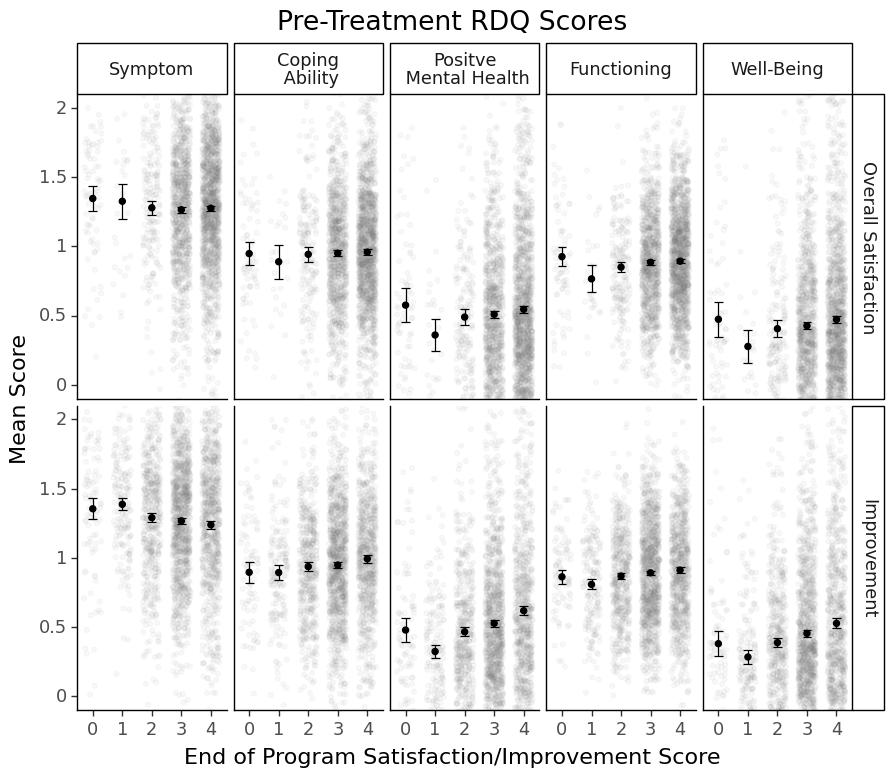

<ggplot: (8789470698478)>

In [20]:
def facet_label(s):
    if 'sym' in s: return('Symptom')
    if 'cope' in s: return ('Coping\n Ability')
    if 'pmh' in s: return('Positve\n Mental Health')
    if 'fun' in s: return ('Functioning')
    if 'well' in s: return('Well-Being')
    if 'overall' in s: return('Overall Satisfaction')
    if 'imprv' in s: return('Improvement')
    
ggplot(df_long0, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     coord_cartesian(ylim = (0,2)) + \
     xlab('End of Program Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Pre-Treatment RDQ Scores')


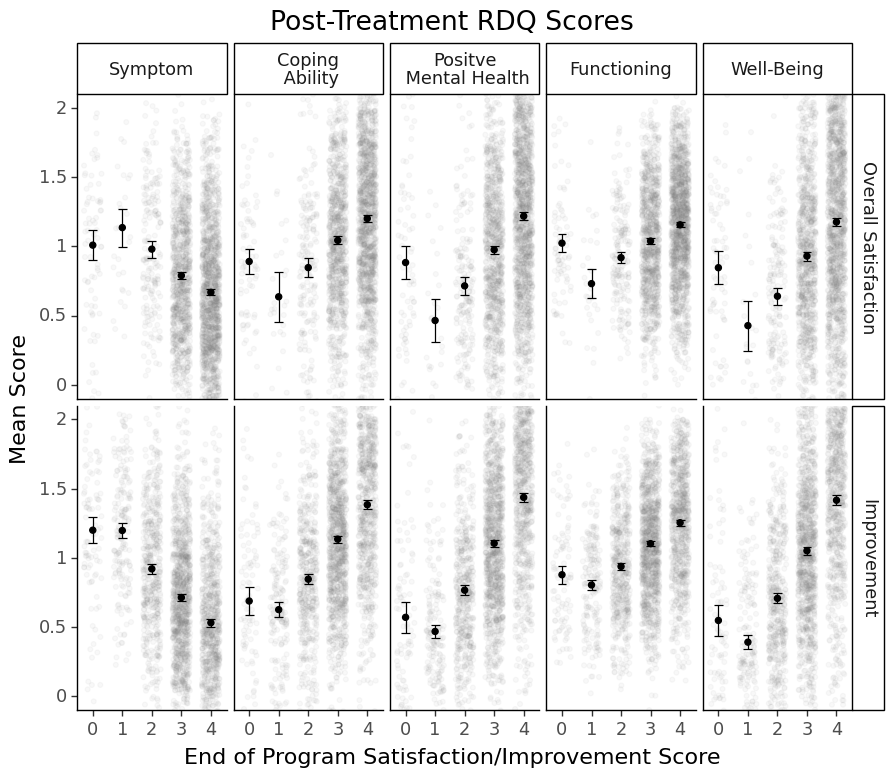

<ggplot: (8790369126066)>

In [641]:
ggplot(df_long, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     coord_cartesian(ylim = (0,2)) + \
     xlab('End of Program Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Post-Treatment RDQ Scores')

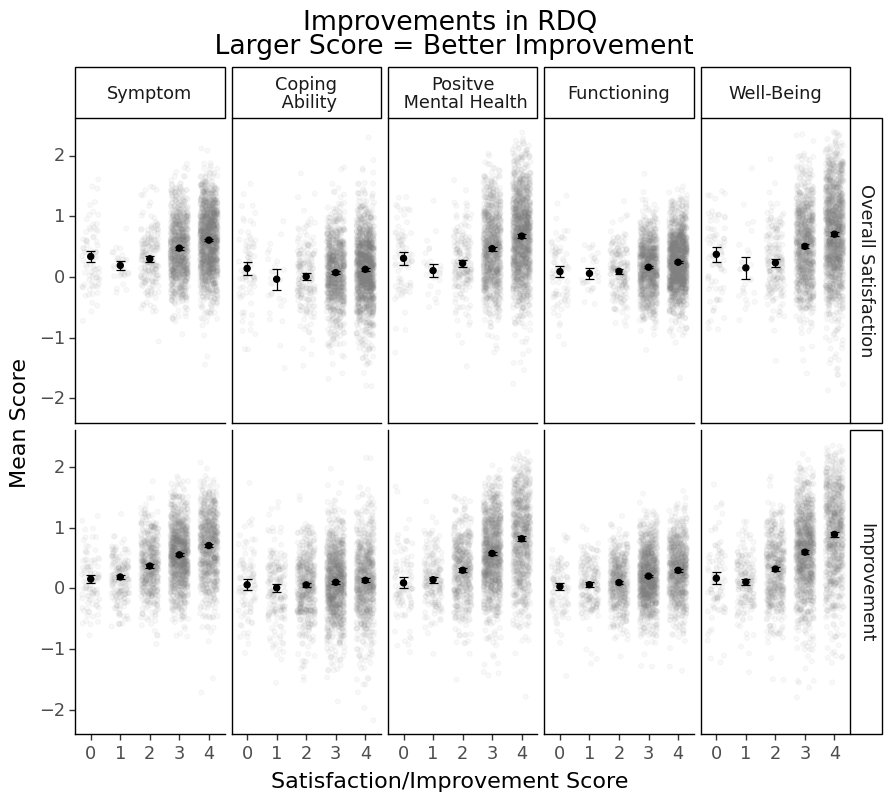

<ggplot: (8789473406946)>

In [21]:
ggplot(df_long2, aes(x='satvalue', y='rdqvalue')) + \
     facet_grid('satvar ~ rdqvar', labeller = facet_label) + \
     geom_jitter(alpha = 0.05, width = 0.3, color = 'grey') + \
     stat_summary(fun_y = np.mean, geom = 'point', size = 2) + \
     stat_summary(fun_data = 'mean_se', fun_args = {'mult':1.96}, geom = 'errorbar', width = 0.3) + \
     xlab('Satisfaction/Improvement Score') + ylab('Mean Score') + \
     theme_classic(base_size = 16) + theme(figure_size = (10,8)) + \
     ggtitle('Improvements in RDQ\n Larger Score = Better Improvement')

In [22]:
df

,ID1,overall1,imprv1,rdqpre_1_1,rdqpre_2_1,rdqpre_3_1,rdqpre_4_1,rdqpre_5_1,rdqpre_6_1,rdqpre_7_1,...,Relationship_1,Education_1,Sexuality_1,OtherSexuality_1,PrimaryLast,change_sym,change_cope,change_pmh,change_fun,change_well
2,1364.0,2.0,2.0,1,0,0,0,0,1,0,...,Never married,Completed graduate/professional school,NaN,,Primary Case,-0.20,0.0,-0.416667,-0.225000,-0.375000
3,1341.0,4.0,4.0,2,2,2,2,0,2,0,...,Separated,Some college,NaN,,Primary Case,0.32,0.6,0.416667,0.000000,0.750000
6,1356.0,4.0,3.0,1,0,0,1,0,1,0,...,Separated,Some graduate/professional school,NaN,,Primary Case,-0.24,0.4,0.166667,-0.700000,0.446429
9,1339.0,4.0,4.0,2,2,2,0,2,2,0,...,Never married,Graduated 2 year college,NaN,,Primary Case,0.88,1.0,0.916667,0.911111,-0.375000
12,1359.0,3.0,3.0,1,2,2,0,2,2,0,...,Living with someone,Graduated HS,NaN,,Primary Case,0.36,0.6,0.916667,0.200000,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3438,7236.0,4.0,2.0,2,1,2,0,1,0,1,...,NaN,NaN,NaN,NaN,NaN,0.12,-0.2,0.333333,-0.200000,0.125000
3440,7241.0,4.0,3.0,2,1,1,0,2,0,2,...,NaN,NaN,NaN,NaN,NaN,0.76,-0.2,1.083333,0.400000,1.250000
3441,7245.0,3.0,3.0,2,2,2,0,2,2,0,...,NaN,NaN,NaN,NaN,NaN,1.32,0.8,1.333333,0.100000,1.250000
3442,7249.0,4.0,4.0,0,0,0,0,0,0,0,...,NaN,NaN,NaN,NaN,NaN,0.20,-0.4,0.083333,0.000000,0.000000


In [130]:
from sklearn import cluster
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import metrics

In [173]:
X = df[df.mddrnp_1.str.contains('Curr, Prin') | df.mddsnp_1.str.contains('Curr, Prin')]
X[['mddrnp_1', 'mddsnp_1']]
Xpre = X.filter(regex='rdqpre')
Xpost = X.filter(regex='rdqpost')
Xchange = 

In [195]:
Xpre.columns = Xpre.columns.str.replace('pre','')
Xpost.columns = Xpost.columns.str.replace('post','')

In [200]:
Xchange = Xpre.astype('float').subtract(Xpost.astype('float'), axis = 0, fill_value = 0)

In [268]:
Xpost_group = X.filter(regex='^post_')
Xpost_group
Xchange_group = X.filter(regex='^change_')
Xchange_group

,change_sym,change_cope,change_pmh,change_fun,change_well
17,0.840000,0.6,1.750000,0.000000,0.750000
18,0.920000,-0.2,0.250000,-0.200000,0.625000
26,0.120000,0.6,0.666667,0.100000,0.875000
27,0.120000,0.0,0.083333,0.200000,0.125000
30,0.240000,0.2,0.416667,0.200000,0.250000
...,...,...,...,...,...
3408,0.223333,-0.2,-0.083333,-0.200000,0.250000
3409,0.683333,-0.4,0.916667,0.433333,1.571429
3411,0.080000,0.0,-0.083333,0.200000,0.375000
3412,0.080000,0.0,-0.083333,0.200000,0.375000


In [269]:
#Imputation 
target = Xchange_group
imp = IterativeImputer(max_iter=10, random_state=0)
imp.fit(target)
IterativeImputer(random_state=0)
X_imp = imp.transform(target)

In [270]:
distortions = []
for k in range(1,10):
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X_imp)
    distortions.append(kmeanModel.inertia_)
    

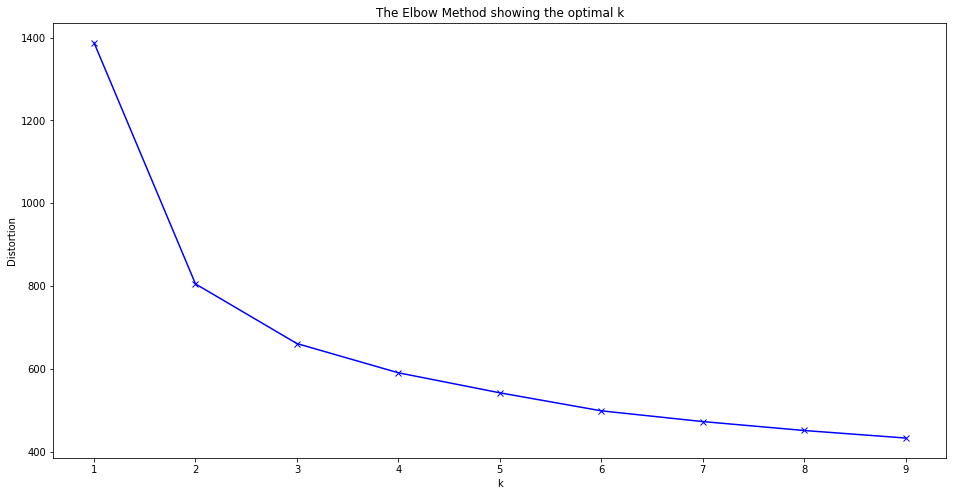

In [271]:
import matplotlib.pyplot as plt
plt.figure(figsize=(16,8))
plt.plot(range(1,10), distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [207]:
metrics.silhouette_score(X_imp, labels, metric='euclidean')

0.16056297180083406

In [272]:
kmeanModel = KMeans(n_clusters=3)
kmeanModel.fit(X_imp)
distortions.append(kmeanModel.inertia_)
labels = kmeanModel.labels_

In [273]:
X['labels'] = labels

In [274]:
print(X[labels == 0].change_sym.mean(),
      X[labels == 0].change_pmh.mean(),
      X[labels == 0].change_cope.mean(),
      X[labels == 0].change_fun.mean(),
      X[labels == 0].change_well.mean())

0.9919848687443797 1.303114478114478 0.2327464788732394 0.5101603835978836 1.3515211640211637


In [275]:
print(X[labels == 1].change_sym.mean(),
      X[labels == 1].change_pmh.mean(),
      X[labels == 1].change_cope.mean(),
      X[labels == 1].change_fun.mean(),
      X[labels == 1].change_well.mean())

0.22527080022098137 0.09210858585858588 -0.06646778042959427 0.02005070546737213 0.025019334880123745


In [276]:
print(X[labels == 2].change_sym.mean(),
      X[labels == 2].change_pmh.mean(),
      X[labels == 2].change_cope.mean(),
      X[labels == 2].change_fun.mean(),
      X[labels == 2].change_well.mean())

0.5745748075251181 0.6360844469540122 0.1708597603946441 0.21843636005126688 0.6972789115646258


In [261]:
print(X.imprv1[labels == 0].mean(),
X.imprv1[labels == 1].mean(),
X.imprv1[labels == 2].mean())

print(X.overall1[labels == 0].mean(),
X.overall1[labels == 1].mean(),
X.overall1[labels == 2].mean())

2.218527315914489 3.5 2.928421052631579
3.07125890736342 3.6666666666666665 3.3628691983122363


In [64]:
metrics.calinski_harabasz_score(X_imp, labels)

992.1556175936948